##### Edoardo Canti
# Role of demographics in online learning; A decision tree based approach


### The aim of the following notebook is to reproduce the results obtained by Saman Rizvi, Bart Rienties and Shakeel Ahmed Khoja in section 4.1 of [their paper](https://www.sciencedirect.com/science/article/abs/pii/S0360131519300818?via%3Dihub).

### While Rizvi, Rienties and Khoja used R programming language and its rpart( ) package for decision tree model implementation, in this work has been used Python programming language and [ScikitLearn](https://scikit-learn.org/stable/).

### Dataset: [OULAD](https://analyse.kmi.open.ac.uk/open_dataset)

#### A very short review of the paper

Rizvi et al. research was not the first work to prove the impact of student's individual characteristics on their learning outcomes, but has been one of the fewest that considered learning outcomes related to the course progression. 

By looking at the [OULAD dataset documentation](https://analyse.kmi.open.ac.uk/open_dataset#description) we can see that progression is represented by date_submitted attribute in studentAssessment table.

With their work they proved not only that individual learner's characteristics impact on their learning outcomes but also that the impact of each individual characteristics changes over time! 

So now we could be interested in which individual characteristic impacts more on learning outcomes (on avarage, since we are considering these as time goes on).

Now the only thing left to explain is which demographics characteristic Rizvi et al. used for their work?
- gender
- age band
- region
- [imd band](https://en.wikipedia.org/wiki/Multiple_deprivation_index)
- disability
- education level

The development of models were divided in two phases. The aim of this project is to reproduce the development of models related to Phase 1.
##### Phase 1
Develop six predictive models:
- S1,...,S5 for each **TMA (Teacher Marked Assignment)**, *Sx is related TMAx ( i=1,___,5 )* 
- S6 for the **final result**

Consider that time progression is represented in TMAs by date attribute in assessment table; in their work (and consequently in this) progession in time is represented by model's name enumeration:
*TMA1 is the first Teacher Marked Assignment, TMA5 in the last Teacher Marked Assignment*.

**Phase 1 was applied over learners of course A (2013 module), who attempted all TMAs, final exam and never unregistered from the course (grand total of 289 learners)**.

Learning outcomes are represented by three distinct values:

| Label       | Related score |
| ----------- | -----------   |
| Fail        | < 55          |
| Pass        | >= 55         |
| Distinction | >= 85         |

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import preprocessing
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.tree import export_text
from sklearn.tree import export_graphviz
import graphviz

## Dataset reading

#### CHANGE THE FOLLOWING CELL INCLUDING THE PATHS OF THE DATASETS

In [8]:
asmnt = pd.read_csv("anonymisedData/assessments.csv")
crs = pd.read_csv("anonymisedData/courses.csv")
std_asmnt = pd.read_csv("anonymisedData/studentAssessment.csv")
std_info = pd.read_csv("anonymisedData/studentInfo.csv")
std_reg = pd.read_csv("anonymisedData/studentRegistration.csv")

## Data filtering
Recall on which student we need for Phase 1:
- Registered to course A in 2013
- Attempted all TMAs (five)
- Attempted final exam
- Never unregistered until the end of the course

In [9]:
# Considering only those assessments related to 2013 module presentation (actually of each Course)
asmnt13 = asmnt[(asmnt['code_presentation']=="2013J")|(asmnt['code_presentation']=="2013B")]
asmnt13

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
...,...,...,...,...,...,...
181,GGG,2013J,37423,CMA,229.0,0.0
182,GGG,2013J,37415,TMA,61.0,0.0
183,GGG,2013J,37416,TMA,124.0,0.0
184,GGG,2013J,37417,TMA,173.0,0.0


In [10]:
# Filtering those student that never unregistered from the course
# Student who completed the course have date_unregistration attribute null in table studentRegistration
never_unregistered = std_reg[std_reg['date_unregistration'].isnull()]
never_unregistered

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN
5,AAA,2013J,38053,-110.0,NaN
...,...,...,...,...,...
32587,GGG,2014J,2620947,-23.0,NaN
32588,GGG,2014J,2640965,-4.0,NaN
32589,GGG,2014J,2645731,-23.0,NaN
32590,GGG,2014J,2648187,-129.0,NaN


In [11]:
# We already had 2013 related assessments, now filtering those related to course A
asmnt13_courseA = asmnt13[asmnt13['code_module']=="AAA"]
asmnt13_courseA

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
5,AAA,2013J,1757,Exam,NaN,100.0


In [12]:
# Considering only students enrolled to course A
std_reg = std_reg[std_reg['code_module']=='AAA']

# From students enrolled to course A extract those enrolled in 2013
std_reg = std_reg[(std_reg['code_presentation']=="2013J")|(asmnt['code_presentation']=="2013B")]

# That never unregistered
# Student who completed the course have date_unregistration attribute null in table studentRegistration
std_reg = std_reg[std_reg['date_unregistration'].isnull()]

std_reg

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN
5,AAA,2013J,38053,-110.0,NaN
...,...,...,...,...,...
378,AAA,2013J,2689958,-71.0,NaN
379,AAA,2013J,2691206,-109.0,NaN
380,AAA,2013J,2691244,-87.0,NaN
381,AAA,2013J,2694424,-170.0,NaN


In [13]:
# Merging students assessments with those assessments just extracted on id_assessmments
# this means that now in this table every entry represent student assessments and also
# gives infos about the assessment itself
oxe = std_asmnt.merge(asmnt13_courseA, on=['id_assessment'])
oxe

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0
...,...,...,...,...,...,...,...,...,...,...
1628,1756,572652,215,0,76.0,AAA,2013J,TMA,215.0,30.0
1629,1756,580389,215,0,67.0,AAA,2013J,TMA,215.0,30.0
1630,1756,588775,213,0,81.0,AAA,2013J,TMA,215.0,30.0
1631,1756,591774,215,0,60.0,AAA,2013J,TMA,215.0,30.0


In [14]:
# For each student in oxe, searching for those who related to 5 assessments
five_tmas_stud = []
for ide in oxe['id_student']:
    k = oxe[oxe['id_student']==ide]
    if len(k) == 5:
        five_tmas_stud.append(ide)

print(len(five_tmas_stud))

# Students enrolled in 2013 in course A, never unregistered, related to 5 assessments
std_reg = std_reg.loc[std_reg['id_student'].isin(five_tmas_stud)] 

1455


In [15]:
# Now extract the info (demographics of those students)
# by looking at the resulting dataframe we note that there are also student related to other courses and 
# other presentations
std_info = std_info.loc[std_info['id_student'].isin(std_reg['id_student'])]
std_info

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
5,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
379,AAA,2013J,2691206,F,West Midlands Region,A Level or Equivalent,50-60%,0-35,0,60,N,Distinction
381,AAA,2013J,2694424,M,East Anglian Region,A Level or Equivalent,70-80%,35-55,0,120,N,Pass
382,AAA,2013J,2698257,M,East Midlands Region,Lower Than A Level,60-70%,0-35,0,120,N,Pass
651,AAA,2014J,1472925,F,East Anglian Region,Lower Than A Level,40-50%,35-55,1,60,Y,Pass


In [16]:
# Need to clean again
std_info = std_info.loc[(std_info['code_module'] == "AAA") & ((std_info['code_presentation'] == "2013J")|(std_info['code_presentation'] == "2013B"))]
std_info

# Did all attempted final exam?
std_info['final_result'].isnull().values.any() #yes

False

So at this point std_info contains only students (learners):
- in course A, 
- of year 2013, 
- which never unenrolled,
- which attempted all five TMAs
- that attempted final exam

Now need to extract the correct assessments:

In [17]:
# Taking only those assessments related to student in std_info
std_asmnt = std_asmnt.loc[std_asmnt['id_student'].isin(std_info['id_student'])]
std_asmnt

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
...,...,...,...,...,...
138823,34893,295741,226,0,89.0
139680,34894,295741,226,0,67.0
140871,34895,295741,226,0,78.0
141100,34896,295741,226,0,72.0


In [18]:
#take only tmas from asmnt
asmnt = asmnt.loc[(asmnt['assessment_type']=="TMA") & (asmnt['code_module']=="AAA") & 
                  ((asmnt['code_presentation']=="2013J") | (asmnt['code_presentation']=="2013B"))]
asmnt

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [19]:
#taking these out from std_asmnt
std_asmnt = std_asmnt[std_asmnt['id_assessment'].isin(asmnt['id_assessment'])]
std_asmnt

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
...,...,...,...,...,...
1627,1756,564450,215,0,52.0
1628,1756,572652,215,0,76.0
1629,1756,580389,215,0,67.0
1630,1756,588775,213,0,81.0


In [20]:
# Changing score values in DataFrame since Rizvi et al. worked on this labels rather then numbers

for score in std_asmnt['score']:
    if score < 55:
        std_asmnt['score'] = std_asmnt['score'].replace([score],'Fail')
    elif score >= 85:
        std_asmnt['score'] = std_asmnt['score'].replace([score],'Distinction')
    else:
        std_asmnt['score'] = std_asmnt['score'].replace([score],'Pass')
        
std_asmnt

/var/folders/by/s5tsgrlj5ws2sv5xjl7yqppr0000gn/T/ipykernel_12485/2022955414.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_asmnt['score'] = std_asmnt['score'].replace([score],'Pass')
/var/folders/by/s5tsgrlj5ws2sv5xjl7yqppr0000gn/T/ipykernel_12485/2022955414.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_asmnt['score'] = std_asmnt['score'].replace([score],'Distinction')
/var/folders/by/s5tsgrlj5ws2sv5xjl7yqppr0000gn/T/ipykernel_12485/2022955414.py:5: SettingWithCopyWarning: 
A value is try

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,Pass
1,1752,28400,22,0,Pass
2,1752,31604,17,0,Pass
3,1752,32885,26,0,Pass
4,1752,38053,19,0,Pass
...,...,...,...,...,...
1627,1756,564450,215,0,Fail
1628,1756,572652,215,0,Pass
1629,1756,580389,215,0,Pass
1630,1756,588775,213,0,Pass


## Getting all single TMAs

In [21]:
tma1 = std_asmnt.loc[std_asmnt['id_assessment'] == 1752]
tma2 = std_asmnt.loc[std_asmnt['id_assessment'] == 1753]
tma3 = std_asmnt.loc[std_asmnt['id_assessment'] == 1754]
tma4 = std_asmnt.loc[std_asmnt['id_assessment'] == 1755]
tma5 = std_asmnt.loc[std_asmnt['id_assessment'] == 1756]

## Functions used to deal with TMAs

In [22]:
''' Takes a TMA ad attached to it the infos related to the student related.
    I want to expand the sdt_asmnt (related to a certain tma) with the infos of the student that appears
    in std_asmnt[id_student] '''
def tma_merge(tma:pd.DataFrame) -> pd.DataFrame:
    tma_stud = tma.merge(std_info, on="id_student")
    return tma_stud

tma1_complete = tma_merge(tma1)
tma2_complete = tma_merge(tma2)
tma3_complete = tma_merge(tma3)
tma4_complete = tma_merge(tma4)
tma5_complete = tma_merge(tma5)

tma1_complete

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,1752,11391,18,0,Pass,AAA,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,1752,28400,22,0,Pass,AAA,2013J,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,1752,31604,17,0,Pass,AAA,2013J,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
3,1752,32885,26,0,Pass,AAA,2013J,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
4,1752,38053,19,0,Pass,AAA,2013J,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,1752,2688067,19,0,Pass,AAA,2013J,M,East Anglian Region,A Level or Equivalent,10-20,0-35,0,60,N,Pass
285,1752,2689958,19,0,Distinction,AAA,2013J,M,East Anglian Region,A Level or Equivalent,40-50%,35-55,0,60,N,Distinction
286,1752,2691206,19,0,Distinction,AAA,2013J,F,West Midlands Region,A Level or Equivalent,50-60%,0-35,0,60,N,Distinction
287,1752,2694424,17,0,Distinction,AAA,2013J,M,East Anglian Region,A Level or Equivalent,70-80%,35-55,0,120,N,Pass


In [23]:
''' Used to encode data in TMAs (those obtained before)
    We need to encode data because ScikitLearn DecisionTrees do not accept not numerical features. 
    Note: only features must be numerical, labels not.'''
def tma_encoder(tma_complete:pd.DataFrame) -> pd.DataFrame:
    encoded_tma = tma_complete
    label_encoder = LabelEncoder()
    tma_complete['gender'] = label_encoder.fit_transform(tma_complete['gender'])
    label_encoder_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(label_encoder_name_mapping)
    tma_complete['region'] = label_encoder.fit_transform(tma_complete['region'])
    label_encoder_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(label_encoder_name_mapping)
    tma_complete['highest_education'] = label_encoder.fit_transform(tma_complete['highest_education'])
    label_encoder_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(label_encoder_name_mapping)
    tma_complete['imd_band'] = label_encoder.fit_transform(tma_complete['imd_band'])
    label_encoder_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(label_encoder_name_mapping)
    tma_complete['age_band'] = label_encoder.fit_transform(tma_complete['age_band'])
    label_encoder_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(label_encoder_name_mapping)
    tma_complete['disability'] = label_encoder.fit_transform(tma_complete['disability'])
    label_encoder_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(label_encoder_name_mapping)
    return encoded_tma

tma1_complete = tma_encoder(tma1_complete)

tma2_complete = tma_encoder(tma2_complete)

tma3_complete = tma_encoder(tma3_complete)

tma4_complete = tma_encoder(tma4_complete)

tma5_complete = tma_encoder(tma5_complete)


{'F': 0, 'M': 1}
{'East Anglian Region': 0, 'East Midlands Region': 1, 'Ireland': 2, 'London Region': 3, 'North Region': 4, 'North Western Region': 5, 'Scotland': 6, 'South East Region': 7, 'South Region': 8, 'South West Region': 9, 'Wales': 10, 'West Midlands Region': 11, 'Yorkshire Region': 12}
{'A Level or Equivalent': 0, 'HE Qualification': 1, 'Lower Than A Level': 2, 'Post Graduate Qualification': 3}
{'0-10%': 0, '10-20': 1, '20-30%': 2, '30-40%': 3, '40-50%': 4, '50-60%': 5, '60-70%': 6, '70-80%': 7, '80-90%': 8, '90-100%': 9, nan: 10}
{'0-35': 0, '35-55': 1, '55<=': 2}
{'N': 0, 'Y': 1}
{'F': 0, 'M': 1}
{'East Anglian Region': 0, 'East Midlands Region': 1, 'Ireland': 2, 'London Region': 3, 'North Region': 4, 'North Western Region': 5, 'Scotland': 6, 'South East Region': 7, 'South Region': 8, 'South West Region': 9, 'Wales': 10, 'West Midlands Region': 11, 'Yorkshire Region': 12}
{'A Level or Equivalent': 0, 'HE Qualification': 1, 'Lower Than A Level': 2, 'Post Graduate Qualificat

In [24]:
# Dataframe for the final result
final_complete = tma1_complete.drop(columns = ["id_assessment","date_submitted","is_banked","score","num_of_prev_attempts","studied_credits"])
final_complete

,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,disability,final_result
0,11391,AAA,2013J,1,0,1,9,2,0,Pass
1,28400,AAA,2013J,0,6,1,2,1,0,Pass
2,31604,AAA,2013J,0,7,0,5,1,0,Pass
3,32885,AAA,2013J,0,11,2,5,0,0,Pass
4,38053,AAA,2013J,1,10,0,8,1,0,Pass
...,...,...,...,...,...,...,...,...,...,...
284,2688067,AAA,2013J,1,0,0,1,0,0,Pass
285,2689958,AAA,2013J,1,0,0,4,1,0,Distinction
286,2691206,AAA,2013J,0,11,0,5,0,0,Distinction
287,2694424,AAA,2013J,1,0,0,7,1,0,Pass


## Class defined to respresent each predictive model

In [25]:
class PredictiveTMA:
    
    def __init__(self, tma, name,label):
        self.X = tma[['gender','region','highest_education','imd_band','age_band','disability']]
        self.y = tma[label] #label
        self.name = name
        
    def splitter(self,n,rnd):
        (self.X_train,self.X_test,self.y_train,self.y_test) = train_test_split(self.X,self.y,train_size=n,random_state=rnd)
        report = "X_train size: "+str(len(self.X_train))+ " ; y_train size: "+str(len(self.y_train))
        return report
    
    def get_X_train(self):
        return self.X_train
    
    def get_y_train(self):
        return self.y_train
    
    def get_X_test(self):
        return self.X_test
    
    def get_y_test(self):
        return self.y_test
    
    
    #def get_tree(self,rnd) -> DecisionTreeClassifier:
        #self.tree = DecisionTreeClassifier(random_state=rnd)
        #self.tree.fit(self.X_train,self.y_train) 
        #return tree
        
    def get_tree(self,rnd):
        param_grid = {'random_state':[rnd]}
        clf = GridSearchCV(DecisionTreeClassifier(),param_grid,cv=5)
        clf.fit(self.X, self.y)
        clf = clf.best_estimator_
        self.tree = clf
        return self.tree
    
    def compute_predictions(self):
        self.predictions = self.tree.predict(self.X_test)
        return self.predictions
    
    def compute_accuracy(self):
        self.accuracy = accuracy_score(self.y_test,self.predictions)
        return self.accuracy
    
    def confusion_matrix(self):
        plot_confusion_matrix(self.tree,self.X_test,self.y_test)
        return confusion_matrix(self.y_test,self.predictions)
    
    def compute_precision(self):
        self.precision = precision_score(self.y_test,self.predictions,average=None)
        return self.precision
    
    def compute_recall(self):
        self.recall = recall_score(self.y_test,self.predictions,average=None)
        return self.recall
    
    def check_feature_importance(self):
        self.feats = {} # a dict to hold feature_name: feature_importance
        
        for feature, importance in zip(self.X.columns, self.tree.feature_importances_):
            self.feats[feature] = importance 
        
        self.importance = pd.DataFrame.from_dict(self.feats, orient='index').rename(columns={0: 'feature importance'})
        self.importance.sort_values(by='feature importance')
        self.importance.plot(kind='bar', rot=45, title=str(self.name)+" feature importance.")
        return self.feats
    
    

## Class designed with responsabilites of running test and collecting values

In [26]:
class Tester:
    
    def __init__(self,s1,s2,s3,s4,s5,s6):
        self.models = []
        self.models.append(s1)
        self.models.append(s2)
        self.models.append(s3)
        self.models.append(s4)
        self.models.append(s5)
        self.models.append(s6)
        self.predictions = []
        self.accuracies = []
        self.precisions = []
        self.recalls = []
        self.importances = []
        
    def get_predictions(self):
        return self.predictions
    
    def get_accuracies(self):
        return self.accuracies
    
    def get_precisions(self):
        return self.precisions
    
    def get_recalls(self):
        return self.recalls
    
    def get_importances(self):
        return self.importances
        
    def runner(self,rnd):
        for model in self.models:
            model.splitter(200, rnd)
            decision_tree = model.get_tree(rnd)
            predictions = model.compute_predictions()
            self.predictions.append(predictions)
            accuracy = model.compute_accuracy()
            self.accuracies.append(accuracy)
            precision = model.compute_precision()
            self.precisions.append(precision)
            recall = model.compute_recall()
            self.recalls.append(recall)
            feats = model.check_feature_importance()
            self.importances.append(feats)
    
    def single_test_summary(self, index):
        print("Train Set:\n")
        print(self.models[index].get_X_train())
        print(self.models[index].get_y_train())
        print("----")
        print("Test Set:\n")
        print(self.models[index].get_X_test())
        print(self.models[index].get_y_test())
        print("----")
        print("Predictions: "+str(self.predictions[index]))
        print("----")
        print("Accuracy: "+str(self.accuracies[index]))
        print("----")
        print("Precision: "+str(self.precisions[index]))
        print("----")
        self.models[index].confusion_matrix()
        print("----")
        print("Recall: "+str(self.recalls[index]))
        print("----")
        print("Feature importances: "+str(self.importances[index]))
        print("----")
        
    
    def handle_importances(self):
        self.gender_imp = []
        self.region_imp = []
        self.highestedu_imp = []
        self.imdband_imp = []
        self.ageband_imp = []
        self.disability_imp = []
        
        self.feat_imp = {}
        
        for dic in self.get_importances():
            self.gender_imp.append(dic['gender'])
            self.region_imp.append(dic['region'])
            self.highestedu_imp.append(dic['highest_education'])
            self.imdband_imp.append(dic['imd_band'])
            self.ageband_imp.append(dic['age_band'])
            self.disability_imp.append(dic['disability'])
            
        self.feat_imp['gender'] = self.gender_imp
        self.feat_imp['region'] = self.region_imp
        self.feat_imp['highest_education'] = self.highestedu_imp
        self.feat_imp['imd_band'] = self.imdband_imp
        self.feat_imp['age_band'] = self.ageband_imp
        self.feat_imp['disability'] = self.disability_imp
            
    def plot_importances(self):
        self.handle_importances()
        sns.lineplot(data=self.feat_imp)
        
    def variable_importance_summary(self)->pd.DataFrame:
        d = {}
        d.update({'feature':[]})
        d.update({'min':[]})
        d.update({'max':[]})
        d.update({'avg':[]})
        for key in self.feat_imp.keys():
            min_val = min(self.feat_imp[key])*100
            max_val = max(self.feat_imp[key])*100
            avg_val = np.mean(self.feat_imp[key])*100
            d['feature'].append(key)
            d['min'].append(min_val)
            d['max'].append(max_val)
            d['avg'].append(avg_val)
        df = pd.DataFrame.from_dict(d)
        df.sort_values(by=['avg'])
        return df      

## Creating single models

In [27]:
S1 = PredictiveTMA(tma1_complete, "TMA1", "score")
S1.splitter(200, 42)
decision_tree = S1.get_tree(42)

S2 = PredictiveTMA(tma2_complete, "TMA2", "score")
S2.splitter(200, 42)
decision_tree = S2.get_tree(42)

S3 = PredictiveTMA(tma3_complete, "TMA3", "score")
S3.splitter(200, 42)
decision_tree = S3.get_tree(42)

S4 = PredictiveTMA(tma4_complete, "TMA4", "score")
S4.splitter(200, 42)
decision_tree = S4.get_tree(42)

S5 = PredictiveTMA(tma5_complete, "TMA5", "score")
S5.splitter(200, 42)
decision_tree = S5.get_tree(42)

S6 = PredictiveTMA(final_complete, "TMA6", "final_result")
S6.splitter(200, 42)
decision_tree = S6.get_tree(42)

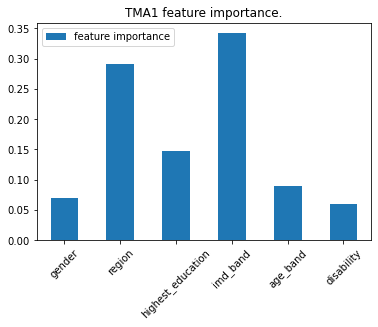

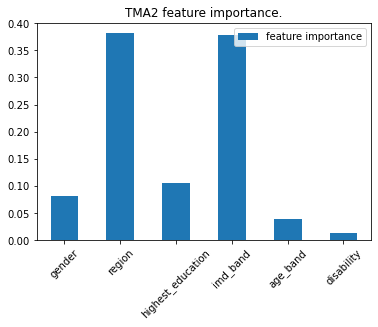

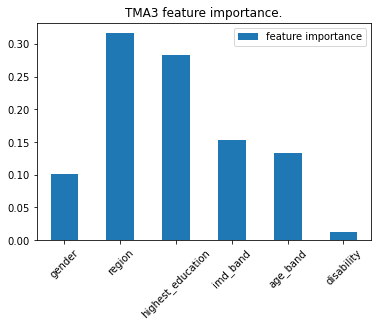

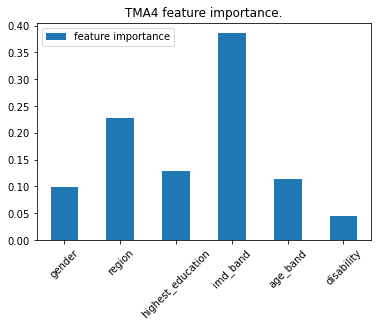

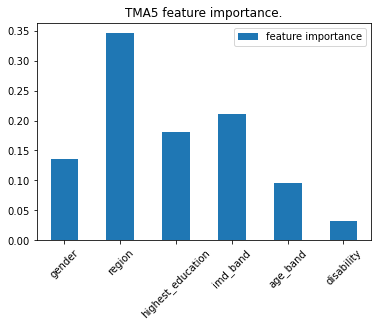

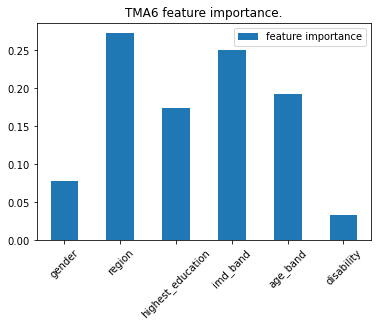

In [28]:
# this will also print a barplot showing feature(demographics) importance of each variable for each model
test = Tester(S1,S2,S3,S4,S5,S6)
test.runner(42)

## Printing out summaries of each model

## S1 summary

Train Set:

     gender  region  highest_education  imd_band  age_band  disability
224       1       8                  0         9         0           0
245       0       5                  2         4         0           0
112       0       0                  1         8         0           0
286       0      11                  0         5         0           0
186       0       0                  2         4         1           1
..      ...     ...                ...       ...       ...         ...
188       0       7                  2         8         1           0
71        1       1                  0         5         0           0
106       1       0                  0         9         1           0
270       0      12                  0         8         0           0
102       0       7                  1         8         0           0

[200 rows x 6 columns]
224           Pass
245           Pass
112           Pass
286    Distinction
186           Pass
          ...    

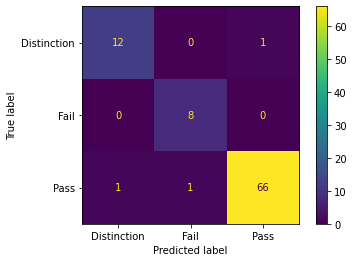

In [29]:
test.single_test_summary(0)

## S2 summary

Train Set:

     gender  region  highest_education  imd_band  age_band  disability
224       0       3                  0         1         0           0
245       1       0                  0         6         0           1
112       1       0                  0         1         0           0
286       1       2                  1         9         0           0
186       1       1                  2         5         0           0
..      ...     ...                ...       ...       ...         ...
188       1       1                  0         5         0           0
71        1       8                  2         9         0           0
106       1       7                  1         9         1           0
270       1      10                  2         2         1           0
102       0       9                  0         8         1           0

[200 rows x 6 columns]
224    Pass
245    Pass
112    Pass
286    Pass
186    Fail
       ... 
188    Pass
71     Fail
106    Pass
270 

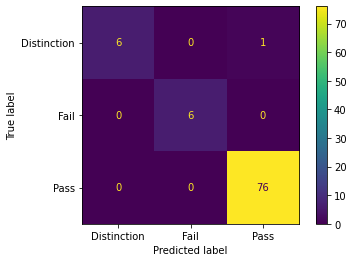

In [30]:
test.single_test_summary(1)

## S3 summary

Train Set:

     gender  region  highest_education  imd_band  age_band  disability
224       0       7                  1         8         0           0
245       1       0                  2         4         0           0
112       1       5                  0         9         0           0
286       1       7                  1         9         0           0
186       1       3                  2         5         1           0
..      ...     ...                ...       ...       ...         ...
188       0       3                  0         1         1           0
71        1       8                  2         8         1           0
106       1       1                  2         5         1           0
270       1       5                  0         6         0           0
102       0       3                  2         1         1           0

[200 rows x 6 columns]
224    Distinction
245           Pass
112           Pass
286           Pass
186           Pass
          ...    

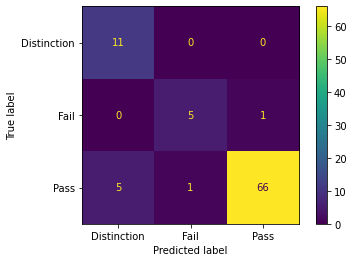

In [31]:
test.single_test_summary(2)

## S4 summary

Train Set:

     gender  region  highest_education  imd_band  age_band  disability
224       1       8                  0         9         0           0
245       0       5                  2         4         0           0
112       0       0                  1         8         0           0
286       0      11                  0         5         0           0
186       0       0                  2         4         1           1
..      ...     ...                ...       ...       ...         ...
188       0       7                  2         8         1           0
71        1       1                  0         5         0           0
106       1       0                  0         9         1           0
270       0      12                  0         8         0           0
102       0       7                  1         8         0           0

[200 rows x 6 columns]
224           Pass
245           Pass
112           Pass
286    Distinction
186           Pass
          ...    

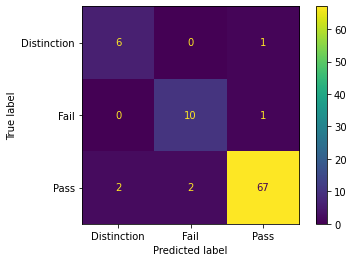

In [32]:
test.single_test_summary(3)

## S5 summary

Train Set:

     gender  region  highest_education  imd_band  age_band  disability
224       0       3                  0         1         0           0
245       1       0                  0         6         0           1
112       1       0                  0         1         0           0
286       1       2                  1         9         0           0
186       1       1                  2         5         0           0
..      ...     ...                ...       ...       ...         ...
188       1       1                  0         5         0           0
71        1       8                  2         9         0           0
106       1       7                  1         9         1           0
270       1      10                  2         2         1           0
102       0       9                  0         8         1           0

[200 rows x 6 columns]
224           Pass
245    Distinction
112           Pass
286           Pass
186           Pass
          ...    

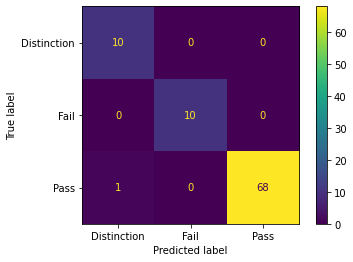

In [33]:
test.single_test_summary(4)

## S6 (final result) summary

Train Set:

     gender  region  highest_education  imd_band  age_band  disability
224       1       8                  0         9         0           0
245       0       5                  2         4         0           0
112       0       0                  1         8         0           0
286       0      11                  0         5         0           0
186       0       0                  2         4         1           1
..      ...     ...                ...       ...       ...         ...
188       0       7                  2         8         1           0
71        1       1                  0         5         0           0
106       1       0                  0         9         1           0
270       0      12                  0         8         0           0
102       0       7                  1         8         0           0

[200 rows x 6 columns]
224           Pass
245           Pass
112           Pass
286    Distinction
186           Fail
          ...    

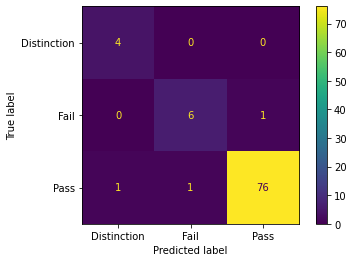

In [34]:
test.single_test_summary(5)

## Features importances over time

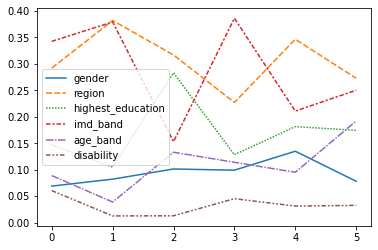

In [35]:
test.plot_importances()

## Showing results 
For each demographic characteristic the following DataFrame shows the minimum and the maximum value reached to its importance (scaled up to 100) and the average. By looking at the average value we can understand which impact more on result and which impact less.

In [37]:
var_im = test.variable_importance_summary()
var_im

,feature,min,max,avg
0,gender,6.905410,13.492264,9.414301
1,region,22.702995,38.186027,30.615499
2,highest_education,10.507228,28.289360,16.983975
3,imd_band,15.305208,38.614321,28.694779
4,age_band,3.899316,19.196171,11.034593
5,disability,1.272400,6.052372,3.256852


## Highlighting results

As depicted in barplots and in the previous graph, we can see that the **impact of each variable on learning outcomes changes over time**. We are now interested in the importance on average. 

By our experiments it turns out that, in decresing order, **the most important variables are**:
- region
- imd band
- highest education
- age band
- gender
- disability


## NOTES:

### LabelEncoder:
Is a function used to encode target values in numerical values in a range.

If an attribute **X** has a not numerical domain **Dom(X)** with cardinality **N** a label encoding applied to **X** will transform **Dom(X)** to {0,...,N-1}.

This has been done because ScikitLearn implementation of decision trees doesn't support not numerical values in X set. However it supports not numerical in y set.

To apply this operation we also came accross OneHotEncoding(). Here is why we didn't used it:

*For simplicity imagine now that imd_band domain contains only three values: Ireland (I), London(L), Wales(W)*.

Consider we are trying to convert *imd_band* values into numerical using *OneHotEncoding*. 
What *OneHotEncoding* does is to create three distinct new *dummy variables* (and so attributes). *Each object* now will have these three new dummy variables indicating if the object itself has *that variable true or false (0,1)*. So if now we will try to *compute variable importance*, we will not have a single variable importance for the variable *imd_band* but instead we will compute the single importances of living in Ireland(I), London(L), Wales(S); this is not what we want.

What happens using LabelEncoder: 
   - imagine Dom(imd_band) = {I,L,W}
   - imagine encoding as I->0, L->1, W->2
    
| id_student  | imd_band      |
| ----------- | -----------   |
| id_a        | 0             |
| id_b        | 2             |
| id_c        | 1             |


What happened using OneHotEncoding: 
   - imagine Dom(imd_band) = {I,L,W}
   - imagine encoding as I->0, L->1, W->2
 
    
| id_student  | is_I          | is_L        | is_W        |
| ----------- | -----------   | ---------   | ---------   |
| id_a        | 1             | 0           | 0           |
| id_b        | 0             | 0           | 1           |
| id_c        | 0             | 1           | 0           |



### Cross Validation
Looking at the PredictiveTMA class you will see two different *get_tree(self)* functions, one of which is commented. We decided to leave that one commented to emphisize what we are going to say.

```
def get_tree(self,rnd) -> DecisionTreeClassifier:
    self.tree = DecisionTreeClassifier(random_state=rnd)
    self.tree.fit(self.X_train,self.y_train) 
    return tree
```
With this snippet of code we are just creating and fitting a Decision Tree.

When using this function to create a *Decision Tree* we just gave to the Tree an *uncertainity on how it will select the sample: random_state=rnd* if *rnd is an integer* it will be used as a *seed to generate random samples*. If we use a *fixed integer for rnd*, we will be sure that every time it will pick the same sammples; this is actually good because we are going to generate six distinct models!

However if we decide that *random_state=None* what happens is that it will produce diffent instances. Buy running the function using *random_state=None*, we arrived to different result with respect to those obtained with a fixed integer random_state. 
What we noticed is that sometimes we obtained same results of Rizvi et al. (when region is the most important variable while other times imd_band was the most one). Maybe there was something we didn't consider in our approach.

It turns out that rpart() package used by Rizvi et al. uses k-fold cross validation.
This is why we used GridSearchCV and builded the Decision Trees using the best estimator (Rizvi et al. didn't specfied the k value of cross validation, we used 5 because is very common).

```
def get_tree(self,rnd):
        param_grid = {'random_state':[rnd]}
        clf = GridSearchCV(DecisionTreeClassifier(),param_grid,cv=5)
        clf.fit(self.X, self.y)
        clf = clf.best_estimator_
        self.tree = clf
        return self.tree
```
With this new *get_tree* function we now started to obtain the same result of Rizvi et al.